In [1]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import numpy as np
import os, sys
import healpy as hp
import matplotlib.pylab as plt
import symlens as s
from symlens import utils
import importlib
from mpi4py import MPI
import pandas as pd
import tools
import ipdb
import argparse
import params as m
# Simulate bias of lensing reconstruction from non-Gaussian kSZ
# experiments configurations           

In [12]:
parser = argparse.ArgumentParser()
parser.add_argument('--experiment', type=str, help='experiment name')
parser.add_argument('--nlev_t',
                    type=float,
                    help='noise level of temperature field')
parser.add_argument('--beam_arcmin', type=float, help='beam_arcmin')
parser.add_argument('--ellmin', type=int, help='ellmin of CMB')
parser.add_argument('--ellmax', type=int, help='ellmax of CMB')
parser.add_argument('--delta_L', type=int, help='delta_L of Kappa')

_StoreAction(option_strings=['--delta_L'], dest='delta_L', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help='delta_L of Kappa', metavar=None)

In [2]:
nlev_t1, beam_arcmin1 = 45, 5
nlev_t2, beam_arcmin2 = 7, 1.4
nlev_t3, beam_arcmin3 = 1, 3
ellmin = 30
ellmax = 4000
delta_L = 200

map_source = m.map_source
ksz_type = m.ksz_type
decmax = m.decmax
width_deg = m.width_deg
px_arcmin = m.px_arcmin

cutouts = m.cutouts

# Use maps provided by websky or Colin
map_path = m.map_path
# Path of output data
data_path = m.data_path

In [3]:
# shape and wcs  of the band
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

In [4]:
cmb_alm = hp.read_alm(map_path + 'lensed_cmb_alm.fits', hdu=1)
# Get cmb band map
cmb_band = curvedsky.alm2map(cmb_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_alm and get ksz band map
print('reading in %s %s kSZ map' % (map_source, ksz_type))
ksz_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_alm.fits')
ksz_band = curvedsky.alm2map(ksz_alm, enmap.empty(band_shape, band_wcs))

# Read in ksz_g_alm  and get ksz_g_band map, 'g' is for gaussian
print('reading in ksz_g map')
ksz_g_alm = hp.read_alm(map_path + f'ksz_{ksz_type}_g_alm_6000.fits')
ksz_g_band = curvedsky.alm2map(ksz_g_alm, enmap.empty(band_shape, band_wcs))

# Read in input kappa map for cross correlation check
print('reading in kappa map')
kap_alm = hp.read_alm(map_path + 'kappa_alm.fits')
kap_band = curvedsky.alm2map(kap_alm, enmap.empty(band_shape, band_wcs))

reading in Colin lt kSZ map
reading in ksz_g map
reading in kappa map


In [8]:
npix = int(width_deg * 60 / px_arcmin)
ntiles = int(np.prod(band_shape) / npix**2)
num_x = int(360 / width_deg)

ells = np.arange(0, ellmax+1, 1)
# lmin, lmax for reconstructed kappa map
Lmin, Lmax = ellmin, ellmax

# deconvolved noise power spectrum
Cl_noise_TT_de1 = (nlev_t1 * np.pi / 180. / 60.)**2 * np.ones(ells.shape) / utils.gauss_beam(ells, beam_arcmin1)**2
Cl_noise_TT_de2 = (nlev_t2 * np.pi / 180. / 60.)**2 * np.ones(ells.shape) / utils.gauss_beam(ells, beam_arcmin2)**2
Cl_noise_TT_de3 = (nlev_t3* np.pi / 180. / 60.)**2 * np.ones(ells.shape) / utils.gauss_beam(ells, beam_arcmin3)**2
# deconvolved noise band map
noise_band1 = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT_de1)
noise_band2 = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT_de2)
noise_band3 = curvedsky.rand_map(band_shape, band_wcs, Cl_noise_TT_de3)
# ksz_cl = pd.read_csv('maps/Colin/smooth_ksz_cl.csv')['Cl']
# cmb_tg
cmb_tg1 = cmb_band + ksz_g_band + noise_band1
#st_tg = stats.Stats()
iy, ix = 0, 0
print('Begin to get <cl_kappa_tg_ave>')
Data_dict = {}

Begin to get <cl_kappa_tg_ave>


[]

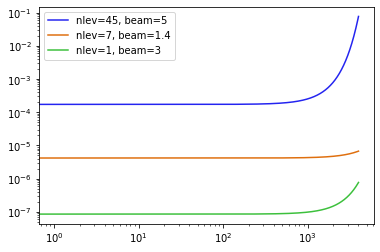

In [11]:
plt.plot(ells, Cl_noise_TT_de1, label='nlev=%s, beam=%s' %(nlev_t1, beam_arcmin1))
plt.plot(ells, Cl_noise_TT_de2, label='nlev=%s, beam=%s' %(nlev_t2, beam_arcmin2))
plt.plot(ells, Cl_noise_TT_de3, label='nlev=%s, beam=%s' %(nlev_t3, beam_arcmin3))
plt.legend()
plt.loglog()

In [94]:
cmb = cmb_band
cmb_n = cmb_band + noise_band
cmb_nt = cmb_band + ksz_band + noise_band

In [95]:
cmb_alm = curvedsky.map2alm(cmb, lmax=ellmax)
cmb_n_alm = curvedsky.map2alm(cmb_n, lmax=ellmax)
cmb_nt_alm = curvedsky.map2alm(cmb_nt, lmax=ellmax)
cmb_cl = hp.alm2cl(cmb_alm)
cmb_n_cl = hp.alm2cl(cmb_n_alm)
cmb_nt_cl = hp.alm2cl(cmb_nt_alm)

[]

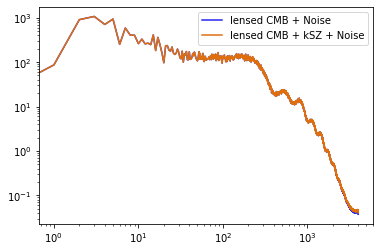

In [97]:
pf = np.arange(0, ellmax+1, 1)
#pf =1
#plt.plot(pf*cmb_cl, label='lensed CMB')
plt.plot(pf*cmb_n_cl, label='lensed CMB + Noise')
plt.plot(pf*cmb_nt_cl, label='lensed CMB + kSZ + Noise')
plt.legend()
plt.loglog()